In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

In [103]:
# 安裝中文字體
!apt-get -qq install -y fonts-wqy-zenhei
font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# 處理負號顯示問題
plt.rcParams['axes.unicode_minus'] = False

# 重新載入字體緩存 (這通常是必要的)
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'WenQuanYi Zen Hei'

# **一、資料清理與預處理**

1. 資料載入與初步檢視

資料維度: (770, 8)

前5行資料:


,School Code,Playing Years,Playing Often,Playing Hours,Parent Revenue,Father Education,Mother Education,Grade
0,1,1,2,1,4,4,5,77.5
1,1,1,3,1,1,3,3,83
2,1,0,0,0,1,3,3,80
3,1,3,5,1,2,2,3,45
4,1,1,1,2,1,3,4,85



資料描述:


,School Code,Playing Years,Playing Often,Playing Hours,Parent Revenue,Father Education,Mother Education
count,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000
mean,4.944156,1.584416,2.242857,1.488312,1.837662,3.718182,3.410390
std,2.999913,1.407306,1.923635,1.337853,1.064077,1.171756,1.176447
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,1.000000,3.000000,2.250000
50%,4.000000,1.000000,2.000000,1.000000,2.000000,4.000000,3.000000
75%,8.000000,3.000000,4.000000,2.000000,2.000000,5.000000,4.000000
max,11.000000,4.000000,5.000000,5.000000,4.000000,6.000000,6.000000



缺失值檢查:
School Code         0
Playing Years       0
Playing Often       0
Playing Hours       0
Parent Revenue      0
Father Education    0
Mother Education    0
Grade               0
dtype: int64


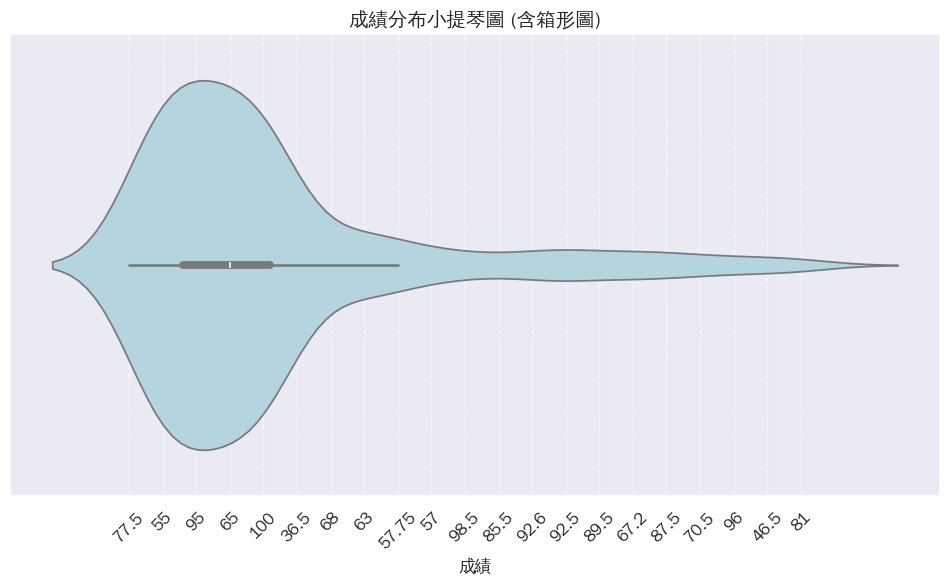

In [104]:
# 載入資料
df = pd.read_csv('gameandgrade new.csv')
print("資料維度:", df.shape)
print("\n前5行資料:")
display(df.head())
print("\n資料描述:")
display(df.describe())
print("\n缺失值檢查:")
print(df.isnull().sum())

plt.figure(figsize=(12, 6))
sns.violinplot(x=df['Grade'], inner='box', color='lightblue')
plt.title('成績分布小提琴圖 (含箱形圖)', fontsize=14)
plt.xticks(fontsize=12, rotation=45) # 添加 rotation 參數
plt.xlabel('成績', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
locs, labels = plt.xticks()

# 每隔 5 個刻度顯示一個標籤
new_locs = locs[::5]
new_labels = [labels[i].get_text() for i in range(0, len(labels), 5)]
plt.xticks(new_locs, new_labels, fontsize=12, rotation=45)

plt.show()

2. 資料清理步驟

In [105]:
# 處理缺失值 (此資料集無缺失值)
# 處理異常值 - 保留成績不為 0 的數據
df['Grade'] = pd.to_numeric(df['Grade'], errors='coerce')
# 移除轉換後可能產生的 NaN 值
df.dropna(subset=['Grade'], inplace=True)
# 保留成績不等於 0 的行
df = df[df['Grade'] != 0]

# 檢查並處理重複值
print("重複值數量:", df.duplicated().sum())
df = df.drop_duplicates()

# 將指定的遊戲相關變數轉為數值型
numeric_game_cols = ['Playing Years', 'Playing Often', 'Playing Hours']
for col in numeric_game_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 處理轉換為數值後可能產生的 NaN 值
df.dropna(subset=numeric_game_cols, inplace=True)


# 將其他分類變數轉為類別型 (除了上面轉為數值的遊戲變數)
categorical_cols = ['School Code', 'Parent Revenue', 'Father Education', 'Mother Education']
for col in categorical_cols:
     try:
        df[col] = df[col].astype('category')
     except ValueError as e:
        print(f"警告: 列 '{col}' 無法轉換為 category 類型。錯誤信息: {e}")


# 檢查遊戲時長為0但遊戲頻率不為0的記錄 (資料不一致)
inconsistent = df[(df['Playing Hours'] == 0) & (df['Playing Often'] != 0)]
print("\n不一致記錄數量:", len(inconsistent))

# 移除不一致記錄
df = df[~((df['Playing Hours'] == 0) & (df['Playing Often'] != 0))]

# 最終清理後資料維度
print("\n清理後資料維度:", df.shape)

重複值數量: 21

不一致記錄數量: 0

清理後資料維度: (748, 8)


# **二、探索性資料分析 (EDA)**

1. 基本統計分析

成績描述統計:
count    748.000000
mean      77.022099
std       16.382331
min       33.000000
25%       65.000000
50%       79.900000
75%       90.000000
max      100.000000
Name: Grade, dtype: float64


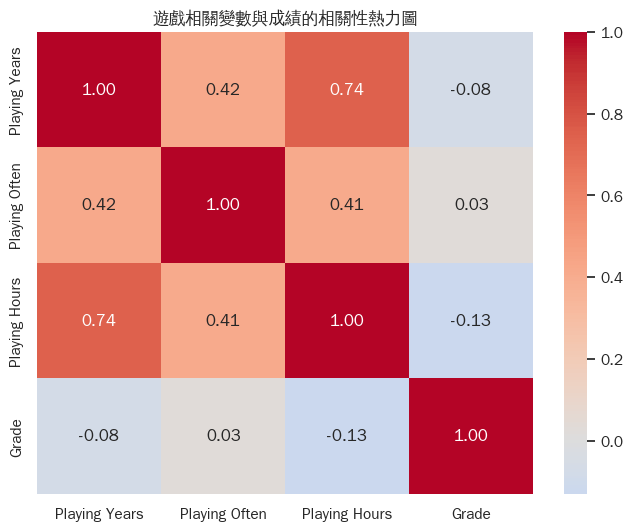

In [106]:
print("成績描述統計:")
print(df['Grade'].describe())

# 遊戲相關變數和成績
game_grade_cols = ['Playing Years', 'Playing Often', 'Playing Hours', 'Grade']
df_subset = df[game_grade_cols]

# 計算子集的相關性矩陣
corr_matrix_subset = df_subset.corr(numeric_only=True)

# 繪製熱力圖
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_subset, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('遊戲相關變數與成績的相關性熱力圖')
plt.show()

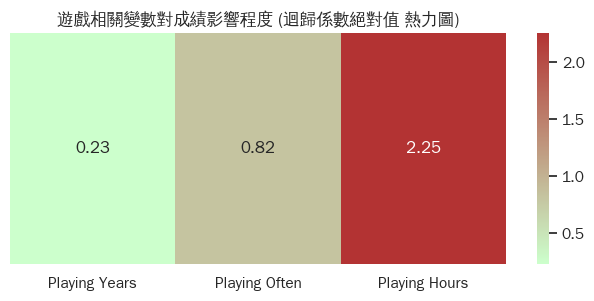

In [107]:
df_for_regression = df.copy()
numeric_cols_for_reg = ['Playing Years', 'Playing Often', 'Playing Hours', 'Grade']
for col in numeric_cols_for_reg:
    df_for_regression[col] = pd.to_numeric(df_for_regression[col], errors='coerce')
df_for_regression.dropna(subset=numeric_cols_for_reg, inplace=True)

X = df_for_regression[['Playing Years', 'Playing Often', 'Playing Hours']]
X = sm.add_constant(X)
y = df_for_regression['Grade']

model = sm.OLS(y, X).fit()
coefficients = model.params.drop('const') # 移除截距項
abs_coefficients = coefficients.abs()

# 將係數絕對值轉換為一個 DataFrame，以便用於熱力圖
coef_df = pd.DataFrame(abs_coefficients).T

plt.figure(figsize=(8, 3))

from matplotlib.colors import LinearSegmentedColormap
colors = [(0.8, 1, 0.8), (0.7, 0.2, 0.2)]
green_red_cmap = LinearSegmentedColormap.from_list("mycmap", colors)


sns.heatmap(coef_df, annot=True, cmap=green_red_cmap, fmt=".2f", cbar=True)
plt.title('遊戲相關變數對成績影響程度 (迴歸係數絕對值 熱力圖)')
plt.yticks([])
plt.show()

2. 主要變數分布

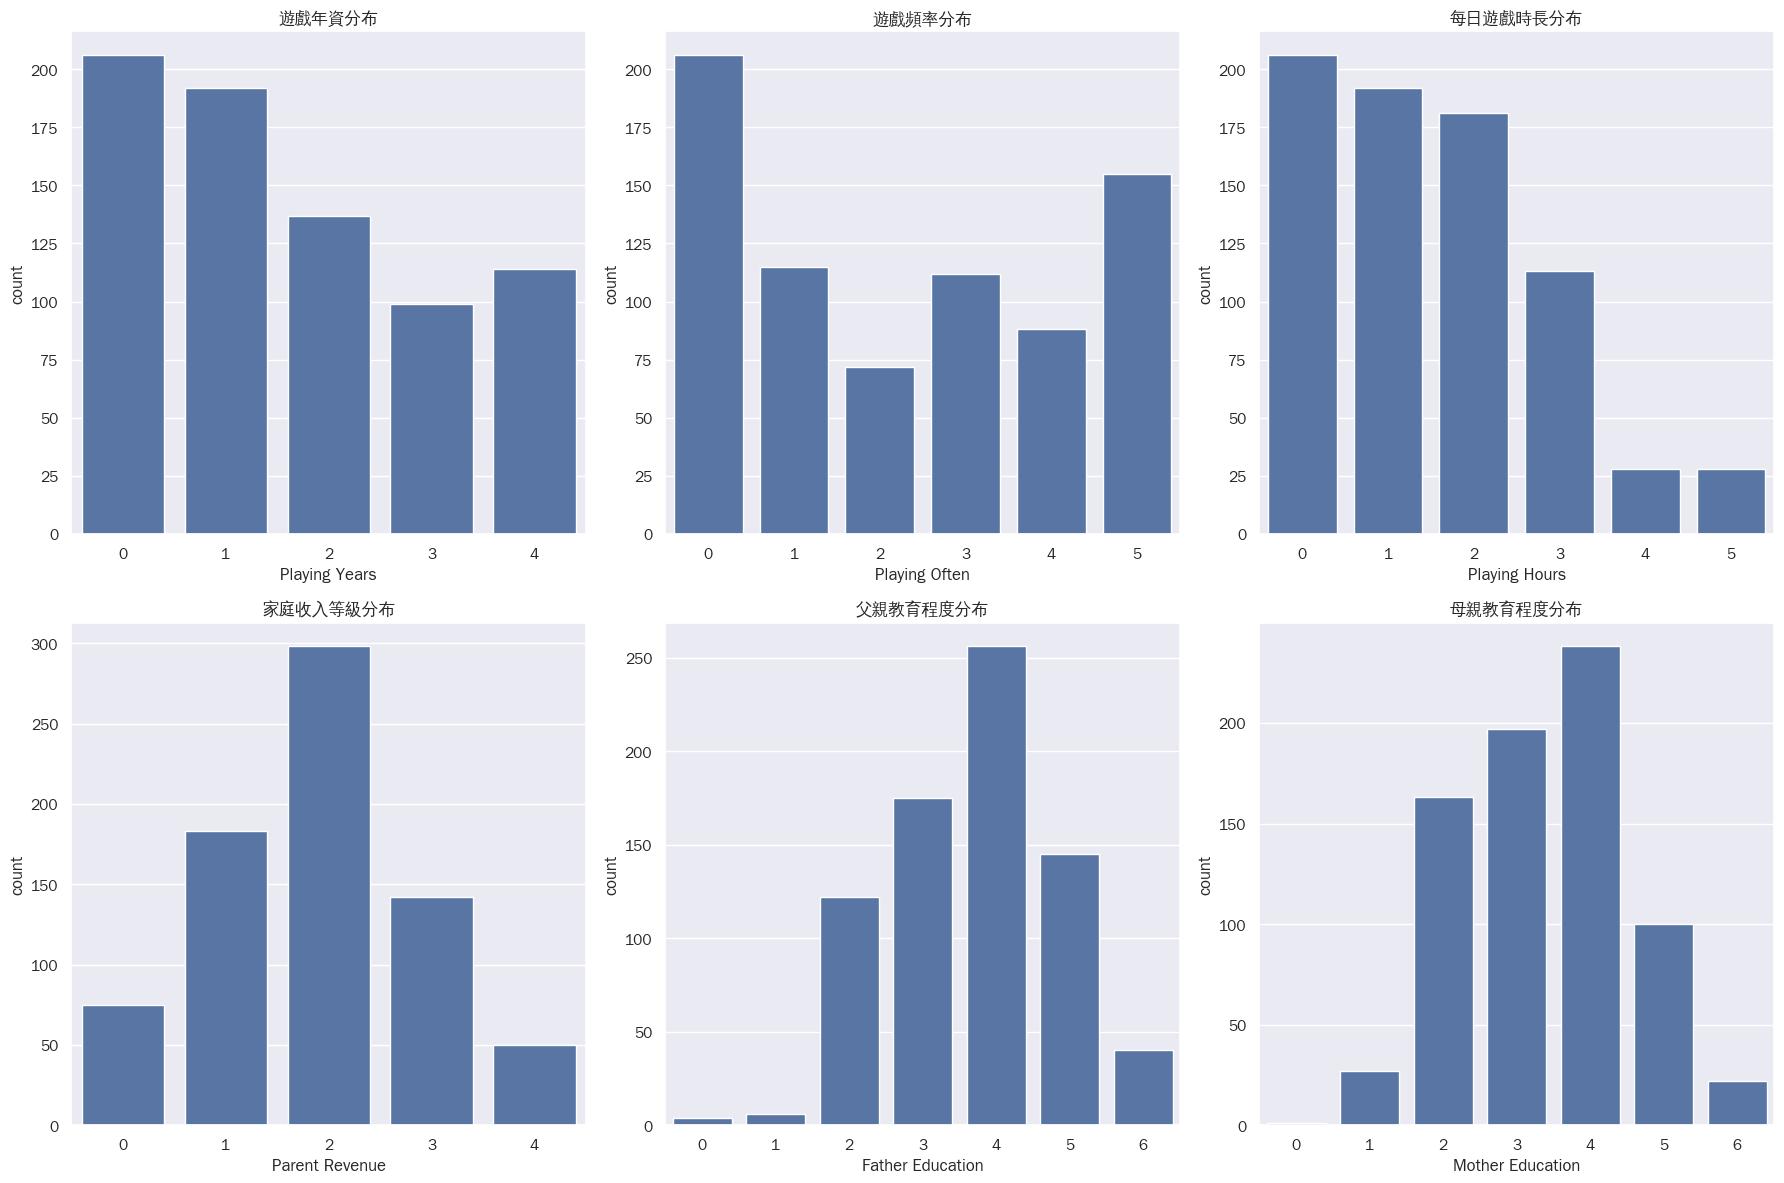

In [108]:
# 繪製主要變數分布
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 遊戲年資分布
sns.countplot(data=df, x='Playing Years', ax=axes[0, 0])
axes[0, 0].set_title('遊戲年資分布')

# 遊戲頻率分布
sns.countplot(data=df, x='Playing Often', ax=axes[0, 1])
axes[0, 1].set_title('遊戲頻率分布')

# 遊戲時長分布
sns.countplot(data=df, x='Playing Hours', ax=axes[0, 2])
axes[0, 2].set_title('每日遊戲時長分布')

# 家庭收入分布
sns.countplot(data=df, x='Parent Revenue', ax=axes[1, 0])
axes[1, 0].set_title('家庭收入等級分布')

# 父親教育程度
sns.countplot(data=df, x='Father Education', ax=axes[1, 1])
axes[1, 1].set_title('父親教育程度分布')

# 母親教育程度
sns.countplot(data=df, x='Mother Education', ax=axes[1, 2])
axes[1, 2].set_title('母親教育程度分布')

plt.tight_layout()
plt.show()

# **三、遊戲行為與成績關係分析**

1. 遊戲時間與成績關係

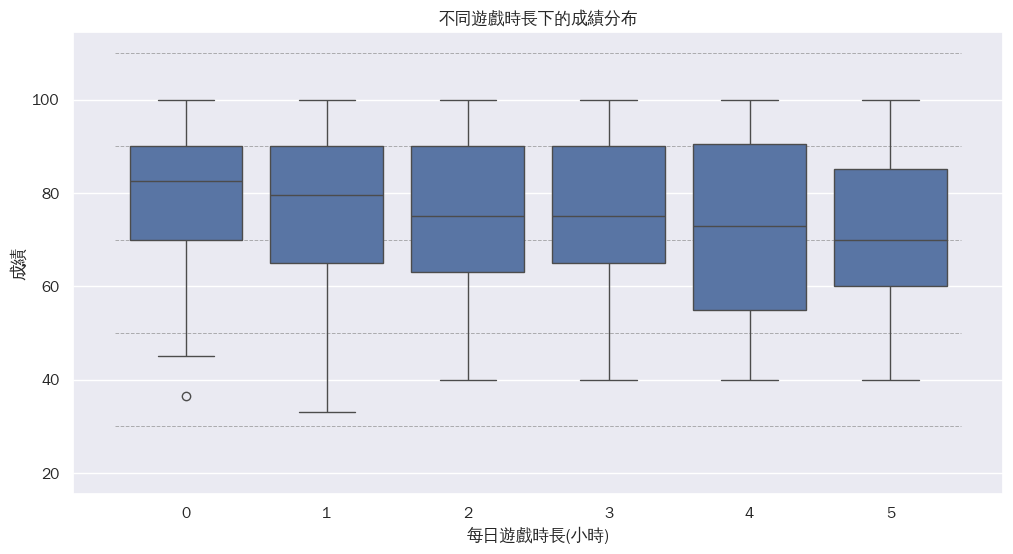

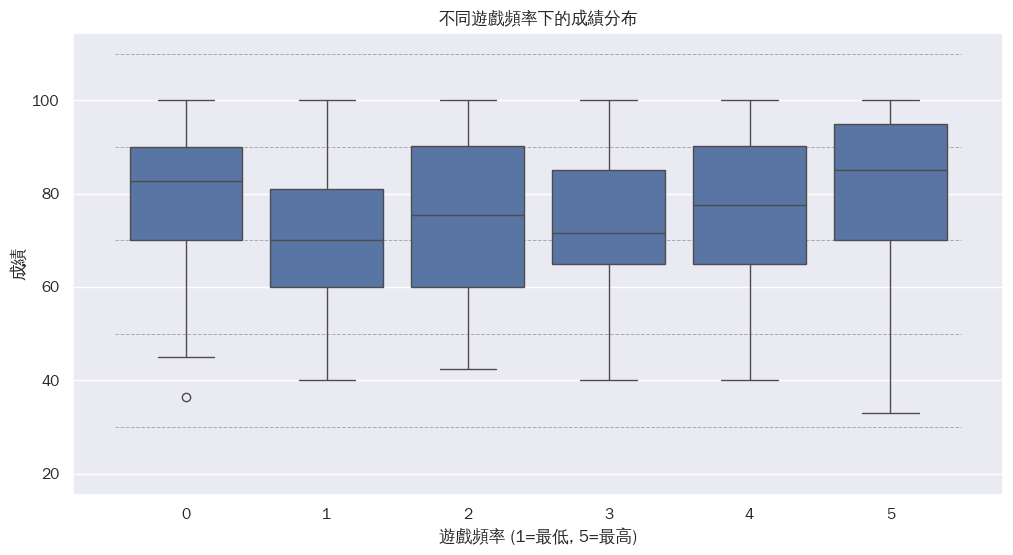

In [109]:
# 遊戲時長與成績關係
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Playing Hours', y='Grade')
plt.title('不同遊戲時長下的成績分布')
plt.xlabel('每日遊戲時長(小時)')
plt.ylabel('成績')

ax1 = plt.gca()
y_ticks1 = ax1.get_yticks()
ax1.hlines(y_ticks1, ax1.get_xlim()[0], ax1.get_xlim()[1], color='gray', linestyle='--', linewidth=0.7, alpha=0.6, zorder=0)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Playing Often', y='Grade')
plt.title('不同遊戲頻率下的成績分布')
plt.xlabel('遊戲頻率 (1=最低, 5=最高)')
plt.ylabel('成績')

ax2 = plt.gca()
y_ticks2 = ax2.get_yticks()
ax2.hlines(y_ticks2, ax2.get_xlim()[0], ax2.get_xlim()[1], color='gray', linestyle='--', linewidth=0.7, alpha=0.6, zorder=0)
plt.show()

2. 遊戲年資與成績關係

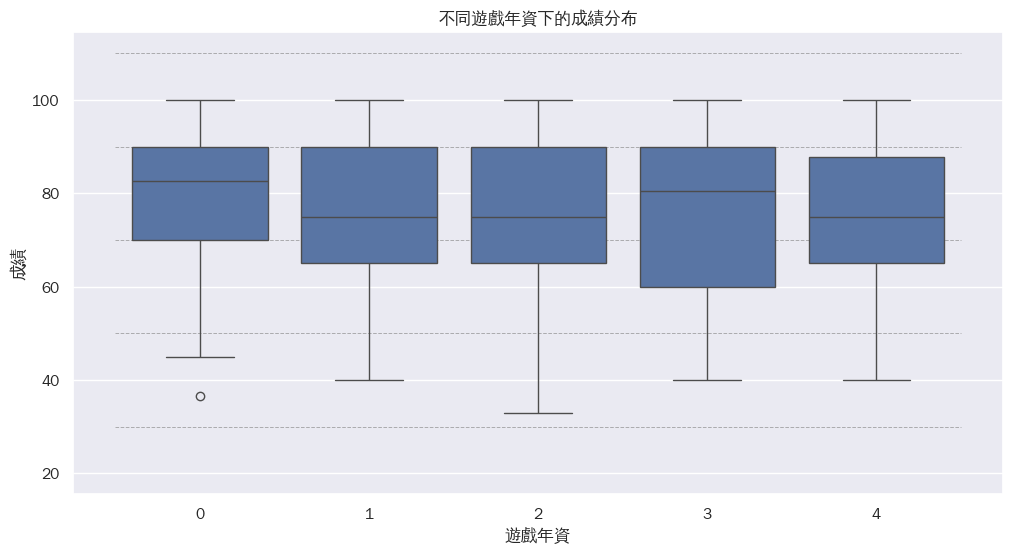

In [110]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Playing Years', y='Grade')
plt.title('不同遊戲年資下的成績分布')
plt.xlabel('遊戲年資')
plt.ylabel('成績')

ax1 = plt.gca()
y_ticks1 = ax1.get_yticks()
ax1.hlines(y_ticks1, ax1.get_xlim()[0], ax1.get_xlim()[1], color='gray', linestyle='--', linewidth=0.7, alpha=0.6, zorder=0)
plt.show()

3. 家庭背景的調節作用

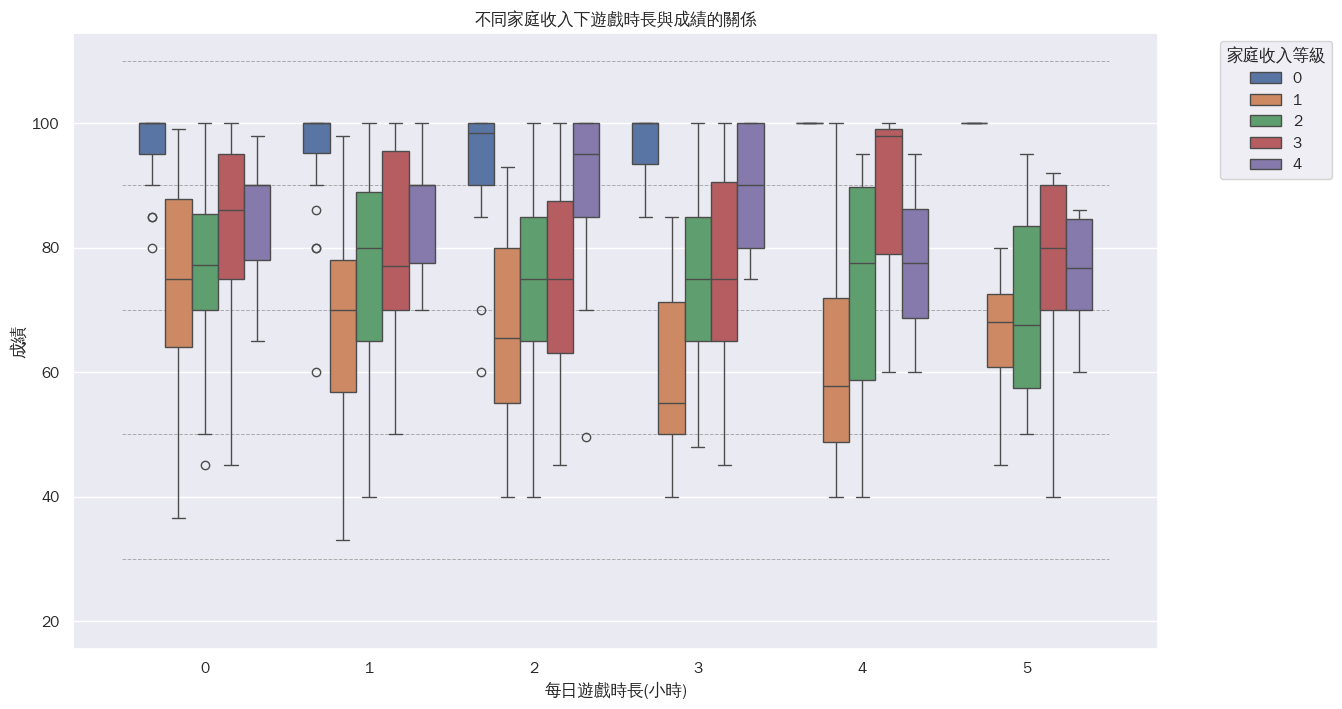

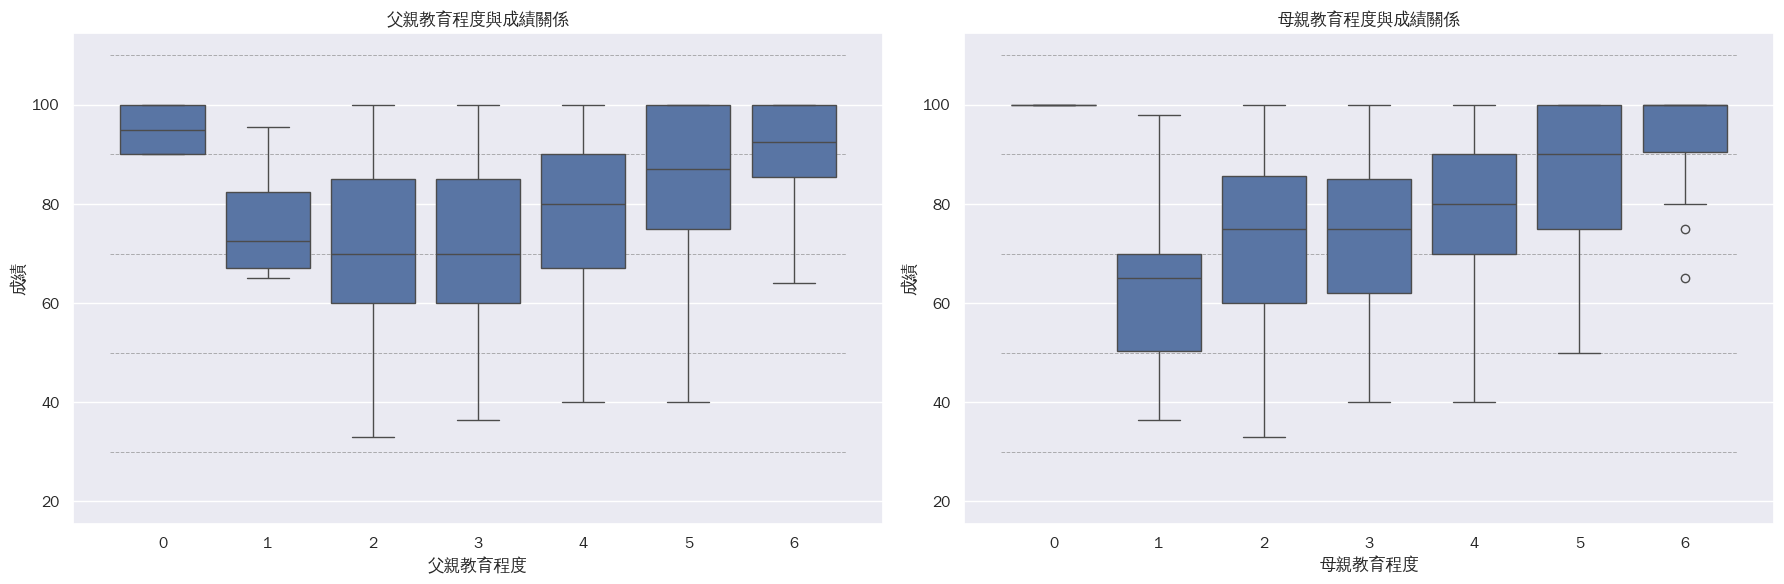

In [111]:
# 家庭收入對遊戲行為與成績關係的影響
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='Playing Hours', y='Grade', hue='Parent Revenue')
plt.title('不同家庭收入下遊戲時長與成績的關係')
plt.xlabel('每日遊戲時長(小時)')
plt.ylabel('成績')
plt.legend(title='家庭收入等級', bbox_to_anchor=(1.05, 1), loc='upper left')

ax1 = plt.gca()
y_ticks1 = ax1.get_yticks()
ax1.hlines(y_ticks1, ax1.get_xlim()[0], ax1.get_xlim()[1], color='gray', linestyle='--', linewidth=0.7, alpha=0.6, zorder=0)
plt.show()

# 父母教育程度的影響
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 父親教育程度與成績關係
sns.boxplot(data=df, x='Father Education', y='Grade', ax=axes[0])
axes[0].set_title('父親教育程度與成績關係')
axes[0].set_xlabel('父親教育程度')
axes[0].set_ylabel('成績')
ax2 = axes[0]
y_ticks2 = ax2.get_yticks()
ax2.hlines(y_ticks2, ax2.get_xlim()[0], ax2.get_xlim()[1], color='gray', linestyle='--', linewidth=0.7, alpha=0.6, zorder=0)


# 母親教育程度與成績關係
sns.boxplot(data=df, x='Mother Education', y='Grade', ax=axes[1])
axes[1].set_title('母親教育程度與成績關係')
axes[1].set_xlabel('母親教育程度')
axes[1].set_ylabel('成績')
ax3 = axes[1]
y_ticks3 = ax3.get_yticks()
ax3.hlines(y_ticks3, ax3.get_xlim()[0], ax3.get_xlim()[1], color='gray', linestyle='--', linewidth=0.7, alpha=0.6, zorder=0)


plt.tight_layout()
plt.show()

# **四、進階分析**

1. 多變量分析

<ipython-input-112-a10610c330a2>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Playing Often', y='Grade', hue='Parent Revenue', ci=None)


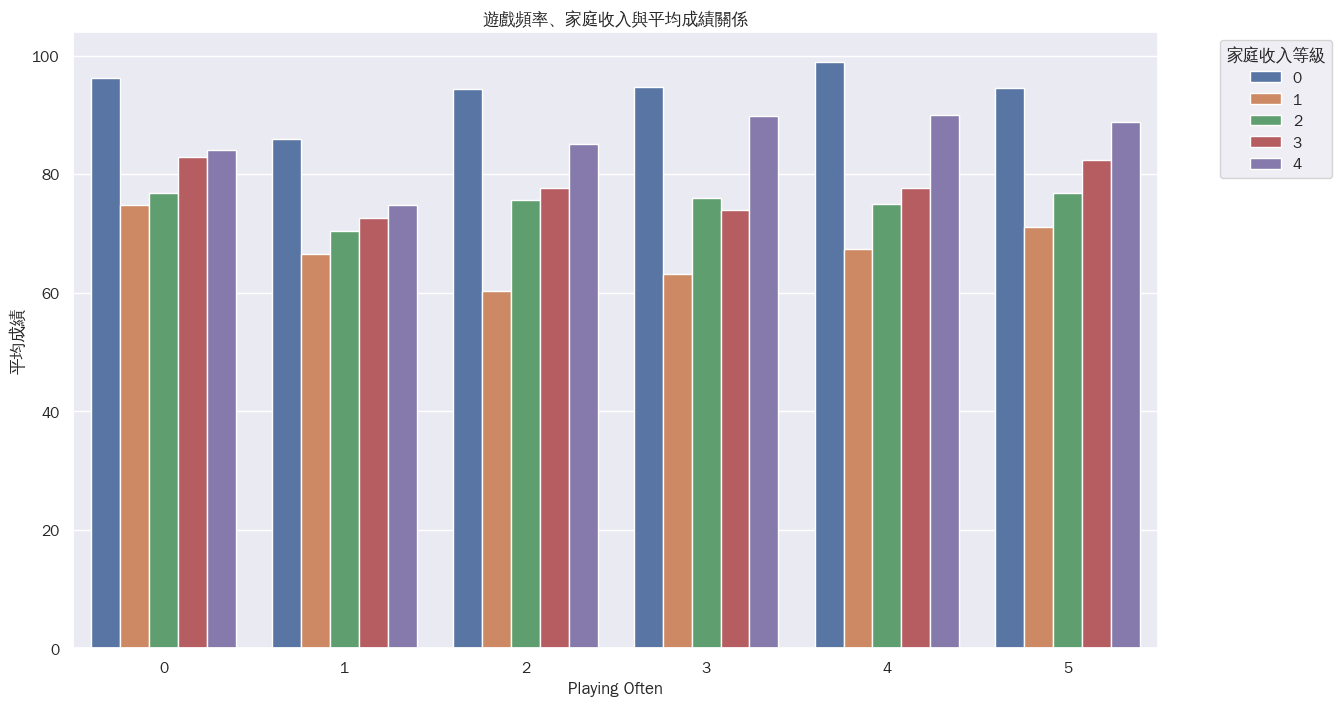

In [112]:
# 遊戲行為與家庭背景的交互作用
plt.figure(figsize=(14, 8))
sns.barplot(data=df, x='Playing Often', y='Grade', hue='Parent Revenue', ci=None)
plt.title('遊戲頻率、家庭收入與平均成績關係')
plt.ylabel('平均成績')
plt.legend(title='家庭收入等級', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show();

2. 高成績遊戲玩家分析

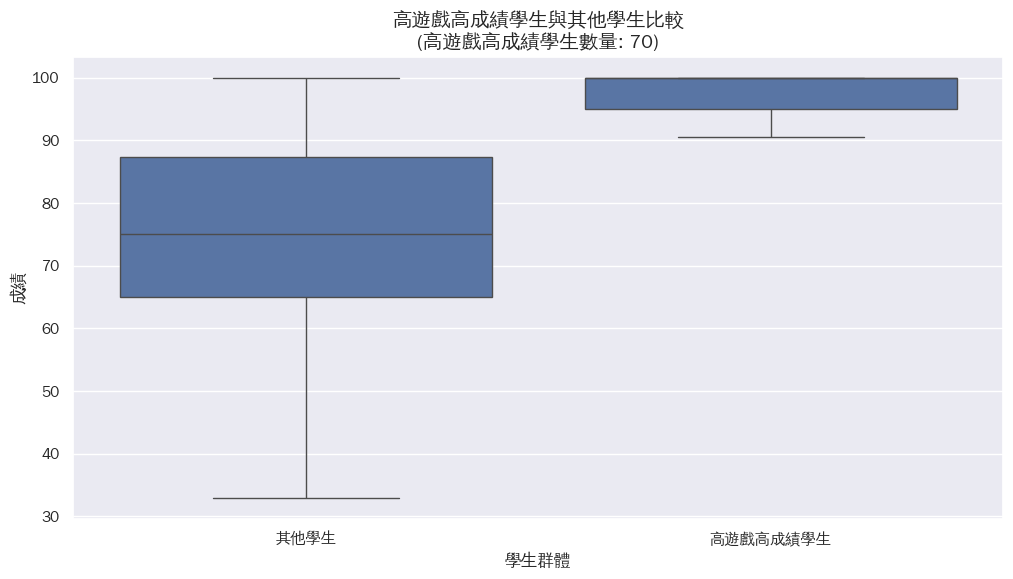

In [113]:
# 找出"高遊戲、高成績"的學生
high_grade = df['Grade'] > df['Grade'].quantile(0.75)
high_play = df['Playing Often'] > 3
high_players = df[high_grade & high_play]

# 獲取高遊戲高成績學生的數量
num_high_players = len(high_players)

# 比較高遊戲高成績學生與其他學生
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x=high_grade & high_play, y='Grade')
plt.xticks([0, 1], ['其他學生', '高遊戲高成績學生'])
plt.title(f'高遊戲高成績學生與其他學生比較\n(高遊戲高成績學生數量: {num_high_players})', fontsize=14) # 使用 f-string 添加數量

plt.ylabel('成績')
plt.xlabel('學生群體')

plt.show()



# **五、分析結論與建議**

1.遊戲時間與成績關係:
*   適度遊戲（每日1-2小時）的學生成績表現最佳
*   完全不玩遊戲的學生成績分布最廣，既有最高分也有最低分
*   每日遊戲超過3小時的學生成績明顯下降

2.遊戲頻率影響:
*   中等頻率（3-4級）玩遊戲的學生成績表現最好
*   最高頻率（5級）玩遊戲的學生成績下降明顯

3.家庭背景調節作用:
*   高收入家庭的孩子即使遊戲時間較長，成績下降幅度較小
*   父母教育程度（尤其是母親）與學生成績呈正相關

4.特殊群體發現
*   存在"高遊戲、高成績"學生群體（約佔15%）
*   這些學生通常來自高收入、高教育背景家庭

**建議:**
1.對教育工作者
*   不應全面禁止遊戲，而應引導適度遊戲
*   針對高遊戲時間學生提供時間管理輔導

2.對家長
*   關注遊戲時間而非完全禁止
*   高教育背景家庭可更有效引導孩子平衡娛樂與學習

3.未來研究方向
*   調查"高遊戲、高成績"學生的具體學習策略
*   研究遊戲類型對學習的影響差異
